Semi-Supervised Learning for Credit-Card Approval Project

Introduction: 
Dataset, that has been retrieved from remote server has over 90% of unlabeled data and 
at most 10% respectively. We need to predict labels of bad client for over 460000 samples, based on 
user personal information, provided. This Notebook prepares the dataset for the potential re-tranining by 
using semi-supervised learning technique

In [465]:
# let's start by loading the dataset 
import pandas, numpy
import seaborn as sns 

applications = pandas.read_csv("application_record.csv")
credit_records = pandas.read_csv("credit_record.csv")

In [466]:
# labeling data, presented in the credit records 

# Relabling Credit Records Dataset

CREDIT_MAPPING = {
    "ID": "client_id",
    "STATUS": "due_status",
    "MONTHS_BALANCE": "balance_month"
}
credit_records.rename(columns=CREDIT_MAPPING, inplace=True)

# Relabling Applications Records Dataset
APPLICATION_MAPPING = {
    "ID": "client_id",
    "CODE_GENDER": "gender",
    "FLAG_OWN_CAR": "has_car",
    "FLAG_OWN_REALTY": "has_realty",
    "CNT_CHILDREN": "total_children",
    "AMT_INCOME_TOTAL": "annual_income",
    "NAME_INCOME_TYPE": "income_category",
    "NAME_EDUCATION_TYPE": "education_category",
    "NAME_FAMILY_STATUS": "family_status",
    "NAME_HOUSING_TYPE": "living_place",
    "DAYS_BIRTH": "birthday",
    "FLAG_MOBIL": "has_mobile_phone",
    "FLAG_PHONE": "has_phone_number",
    "FLAG_WORK_PHONE": "has_work_phone",
    "FLAG_EMAIL": "has_email",
    "CNT_FAM_MEMBERS": "family_size",
    "OCCUPATION_TYPE": "job",
    'DAYS_EMPLOYED': 'days_employed',
}

applications.rename(columns=APPLICATION_MAPPING, inplace=True)


Null Values handling (Application Records)

In [467]:
applications.isnull().sum()

client_id                  0
gender                     0
has_car                    0
has_realty                 0
total_children             0
annual_income              0
income_category            0
education_category         0
family_status              0
living_place               0
birthday                   0
days_employed              0
has_mobile_phone           0
has_work_phone             0
has_phone_number           0
has_email                  0
job                   134203
family_size                0
dtype: int64

In [468]:
missing_job = 'missing'
applications['job'].fillna(value=missing_job, inplace=True)

Null Values Handling (Credit Records)

In [469]:
credit_records.isna().sum()

client_id        0
balance_month    0
due_status       0
dtype: int64

Handling outliers

In [470]:
numeric_features = applications.select_dtypes(include='number').columns
numeric_features

Index(['client_id', 'total_children', 'annual_income', 'birthday',
       'days_employed', 'has_mobile_phone', 'has_work_phone',
       'has_phone_number', 'has_email', 'family_size'],
      dtype='object')

Total Children

<Axes: xlabel='total_children'>

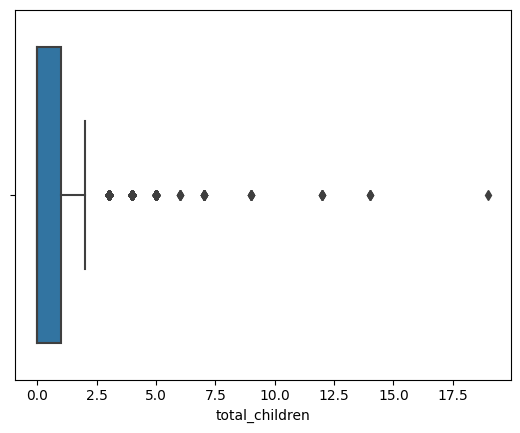

In [471]:
sns.boxplot(x=applications['total_children'])

In [472]:
low, high = numpy.percentile(applications['annual_income'], [25, 75])
iqr = (high - low)
low_fence, high_fence = low - (1.5 * iqr), high + (1.5 * iqr)

outliers = applications.loc[
    (applications["annual_income"] > high_fence) | (applications['annual_income'] < low_fence)
]


print('outliers: ', outliers.shape[0])
print('total samples: ', len(applications))



outliers:  19108
total samples:  438557


Family Size

<Axes: xlabel='family_size'>

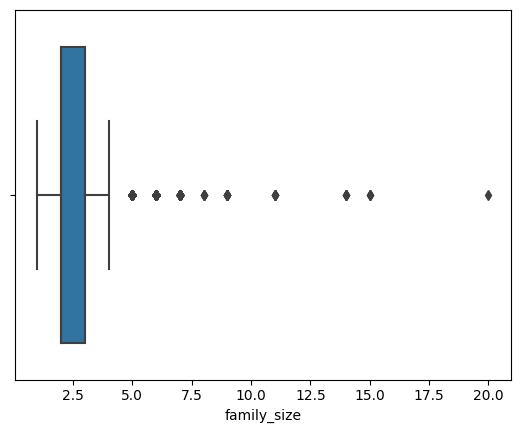

In [473]:
sns.boxplot(x=applications['family_size'])

Feature Engineering

Application Record Features

In [474]:
import math 

applications = applications.drop_duplicates(subset=["client_id"], keep='last', inplace=False)

applications['age'] = applications['birthday'].apply(lambda day: math.floor(abs(day) / 365))
applications['employed'] = applications['days_employed'].apply(lambda days: True if days < 0 else False)

dup_clients = applications['client_id'].value_counts().to_frame("number_of_apps").reset_index()
applications['exp_applicant'] = numpy.where(dup_clients['number_of_apps'] > 1, True, False)

applications.drop(columns=['birthday', 'days_employed'], inplace=True)

def create_married_feature(applications: pandas.DataFrame):

    non_mar_statuses = set(['Single / not married', 'Separated', 'Widow'])
    applications['family_status'] = applications['family_status'].apply(
        func=lambda status: True if status not in non_mar_statuses else False
    )
    return applications.rename(columns={'family_status': 'married'}, inplace=False)


def create_gender_feature(applications: pandas.DataFrame):

    encoded_data = pandas.get_dummies(
        applications['gender']
    ).rename(columns={'F': 'Female', 'M': 'Male'})

    applications = pandas.concat([applications, encoded_data], axis=1)
    applications.drop(columns=['gender'], inplace=True)
    return applications

applications = create_married_feature(applications)
applications = create_gender_feature(applications)

In [475]:
# Cleansing credit records dataset 
DUE_DATATYPES = {
    "0": 0,
    "1": 0,
    "2": 1,
    "3": 1,
    "4": 1,
    "5": 1,
    "X": 0,
    "C": 0
}
credit_records['due_status'] = credit_records['due_status'].map(lambda item: DUE_DATATYPES[item])

Credit Record Features

In [476]:
# introducing credit records features (bad client status)
credit_features = pandas.DataFrame()
credit_features['client_id'] = credit_records['client_id'].unique()
credit_features['overdues'] = pandas.Series(credit_records.groupby('client_id')['due_status'].sum().to_numpy())
credit_features['credit_window'] = numpy.abs(credit_records['balance_month'].min())
credit_features['overdue_perc'] = numpy.round(credit_features['overdues'] / credit_features['credit_window'], 2)

# annotating bad client status
credit_features['bad_client'] = numpy.where(credit_features['overdues'] > 0, True, False)
credit_features = credit_features[['client_id', 'bad_client']]

credit_features['bad_client'].value_counts()

bad_client
False    45318
True       667
Name: count, dtype: int64

Merging tables together

In [477]:
merged_dataset = applications.merge(credit_features, on='client_id', how='left')
merged_dataset

,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_phone_number,has_email,job,family_size,age,employed,exp_applicant,Female,Male,bad_client
0,5008804,Y,Y,0,427500.0,Working,Higher education,True,Rented apartment,1,...,0,0,missing,2.0,32,True,False,False,True,False
1,5008805,Y,Y,0,427500.0,Working,Higher education,True,Rented apartment,1,...,0,0,missing,2.0,32,True,False,False,True,False
2,5008806,Y,Y,0,112500.0,Working,Secondary / secondary special,True,House / apartment,1,...,0,0,Security staff,2.0,58,True,False,False,True,False
3,5008808,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,False,House / apartment,1,...,1,1,Sales staff,1.0,52,True,False,True,False,False
4,5008809,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,False,House / apartment,1,...,1,1,Sales staff,1.0,52,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438505,6840104,N,Y,0,135000.0,Pensioner,Secondary / secondary special,False,House / apartment,1,...,0,0,missing,1.0,62,False,False,False,True,NaN
438506,6840222,N,N,0,103500.0,Working,Secondary / secondary special,False,House / apartment,1,...,0,0,Laborers,1.0,43,True,False,True,False,NaN
438507,6841878,N,N,0,54000.0,Commercial associate,Higher education,False,With parents,1,...,0,0,Sales staff,1.0,22,True,False,True,False,NaN
438508,6842765,N,Y,0,72000.0,Pensioner,Secondary / secondary special,True,House / apartment,1,...,0,0,missing,2.0,59,False,False,True,False,NaN


<Axes: xlabel='annual_income'>

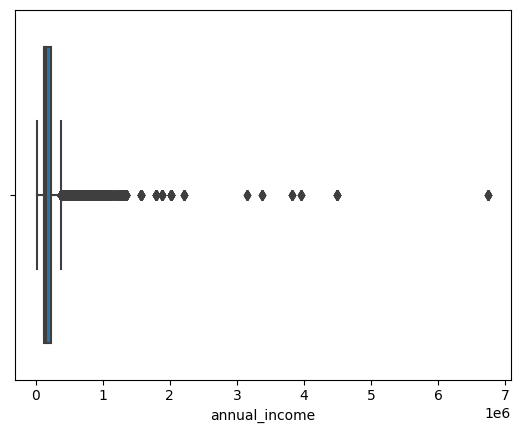

In [478]:
sns.boxplot(x=applications['annual_income'])

In [479]:
low, high = numpy.percentile(merged_dataset['annual_income'], [25, 75])
iqr = (high - low)
low_fence, high_fence = low - (1.5 * iqr), high + (1.5 * iqr)

outliers = merged_dataset.loc[
    (merged_dataset["annual_income"] > high_fence) | (merged_dataset['annual_income'] < low_fence)
]

print('outliers: ', outliers.shape[0])
print('total samples: ', len(merged_dataset))


outliers:  19102
total samples:  438510


In [480]:
# percentage of positive classes 

pos_perc = outliers['bad_client'].value_counts()
pos_perc

bad_client
False    1501
True       28
Name: count, dtype: int64

Dropping outliers

In [481]:
merged_dataset = merged_dataset.loc[
    (merged_dataset['annual_income'] < high_fence) & (merged_dataset['annual_income'] > low_fence)
]
merged_dataset['bad_client'].value_counts()

bad_client
False    34340
True       588
Name: count, dtype: int64

Preparing dataset

In [482]:
def encode_bool_features(dataset: pandas.DataFrame):
    """
    Function standardizes boolean features to the following format 
        True: (Y, 1)
        False: (N, 0)
    Args:
        dataset: pandas.DataFrame object, containing boolean features
    """
    bool_features = ['has_car', 'has_realty', 'has_phone_number', 'has_email', 'has_mobile_phone', 'has_work_phone']
    if not all(feature in dataset.columns for feature in bool_features): return 

    for feature in bool_features:
        dataset[feature] = dataset[feature].map(
            {
                'Y': True,
                'N': False,
                1: True,
                0: False
            }
        )

def encode_bad_client_status(dataset: pandas.DataFrame):
    """
    Function encodes bad client status by applying new category called 'missing'
    """

encode_bool_features(merged_dataset)

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_22726/2245522233.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[feature] = dataset[feature].map(
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_22726/2245522233.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[feature] = dataset[feature].map(
/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_22726/2245522233.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Dataset Splitting (training, testing)

In [483]:
from sklearn.model_selection import train_test_split 

labeled_data = merged_dataset[merged_dataset['bad_client'].notnull()]
unlabeled_data = merged_dataset[merged_dataset['bad_client'].isnull()]

X_labeled = labeled_data.drop(columns=['bad_client'], inplace=False)
Y_labeled = labeled_data['bad_client']


x_train, x_test, y_train, y_test = train_test_split(
    X_labeled, Y_labeled, stratify=Y_labeled, test_size=0.3, random_state=42
)

x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, stratify=y_train, test_size=0.3, random_state=42
)

training_set = pandas.concat([x_train, y_train], axis=1)
testing_set = pandas.concat([x_test, y_test], axis=1)
validation_set = pandas.concat([x_validation, y_validation], axis=1)

print(len(training_set), len(testing_set), len(validation_set))

training_set

17114 10479 7335


,client_id,has_car,has_realty,total_children,annual_income,income_category,education_category,married,living_place,has_mobile_phone,...,has_phone_number,has_email,job,family_size,age,employed,exp_applicant,Female,Male,bad_client
14764,5041918,False,False,0,99000.0,Commercial associate,Secondary / secondary special,True,House / apartment,True,...,False,False,Laborers,2.0,27,True,False,False,True,False
34930,5117647,False,False,1,135000.0,Working,Secondary / secondary special,True,House / apartment,True,...,False,False,Security staff,3.0,30,True,False,False,True,False
15967,5045972,True,False,1,90000.0,Working,Secondary / secondary special,True,With parents,True,...,False,False,Laborers,3.0,24,True,False,False,True,False
7149,5028293,False,True,0,292500.0,Working,Higher education,False,House / apartment,True,...,True,False,Core staff,1.0,54,True,False,True,False,False
17304,5050635,False,False,0,225000.0,State servant,Secondary / secondary special,True,House / apartment,True,...,False,False,Managers,2.0,37,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45319,5136019,True,False,1,351000.0,Commercial associate,Secondary / secondary special,True,House / apartment,True,...,False,False,Private service staff,3.0,44,True,False,False,True,False
2149,5021288,False,True,2,135000.0,Pensioner,Secondary / secondary special,True,House / apartment,True,...,False,False,missing,4.0,60,False,False,True,False,False
21094,5062026,False,True,0,139500.0,Commercial associate,Secondary / secondary special,True,House / apartment,True,...,True,False,missing,2.0,56,True,False,True,False,False
31473,5091857,True,True,0,135000.0,Working,Incomplete higher,True,House / apartment,True,...,False,True,Laborers,2.0,34,True,False,False,True,False


Feature Encoding

In [484]:
from sklearn.preprocessing import OrdinalEncoder

def encode_living_place_feature(dataset: pandas.DataFrame):
    """
    Function encodes `living place` dataset using Ordinal Encoding 
    
    Args:
        dataset: pandas.DataFrame object, containing living_place feature
    """
    if not 'living_place' in dataset.columns: return 
    living_categories = [
        'Co-op apartment',
        'Office apartment',
        'Municipal apartment',
        'Rented apartment', 
        'House / apartment',
        'With parents',
    ]
    encoder = OrdinalEncoder(dtype=numpy.int8, categories=[living_categories])
    dataset['living_place'] = encoder.fit_transform(dataset[['living_place']])


def encode_dataset(merged_dataset: pandas.DataFrame):
    """
    Encodes all feature dataset using appropriate
    feature encoding techniques 
    """
    encode_living_place_feature(merged_dataset)
    return merged_dataset

print(len(training_set), len(testing_set))

training_set = encode_dataset(training_set)
testing_set = encode_dataset(testing_set)
validation_set = encode_dataset(validation_set)

unlabeled_data = encode_dataset(unlabeled_data)

17114 10479


/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_22726/3616153469.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['living_place'] = encoder.fit_transform(dataset[['living_place']])


Removing Redundant and Unncessesary Features

In [485]:
for dataset in [
    training_set, testing_set, validation_set, unlabeled_data
]:
    dataset.drop(
        columns=[
            "client_id",
            "job",
            'has_work_phone',
            'married',
            'family_size',
            'Male',
            'Female',
            'has_phone_number',
            'has_email',
            'education_category',
            'income_category'
        ], inplace=True
    )

/var/folders/gy/ny3nd_gs15z0x1xkkb7gfh8w0000gn/T/ipykernel_22726/1338884007.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(


In [486]:
training_set

,has_car,has_realty,total_children,annual_income,living_place,has_mobile_phone,age,employed,exp_applicant,bad_client
14764,False,False,0,99000.0,4,True,27,True,False,False
34930,False,False,1,135000.0,4,True,30,True,False,False
15967,True,False,1,90000.0,5,True,24,True,False,False
7149,False,True,0,292500.0,4,True,54,True,False,False
17304,False,False,0,225000.0,4,True,37,True,False,False
...,...,...,...,...,...,...,...,...,...,...
45319,True,False,1,351000.0,4,True,44,True,False,False
2149,False,True,2,135000.0,4,True,60,False,False,False
21094,False,True,0,139500.0,4,True,56,True,False,False
31473,True,True,0,135000.0,4,True,34,True,False,False


Semi Supervised Learning Analysis

In [487]:
# Separating data into labeled and unlabeled datasets 

labeled_data = training_set
unlabeled_data = unlabeled_data

In [488]:
# Splitting data into training and testing sets on labeled data for estimating Label Propagation Algorithm

In [489]:
from sklearn.model_selection import train_test_split 
Xl_data, Yl_data = labeled_data.drop(columns=['bad_client']), labeled_data['bad_client']

X_train, X_test, Y_train, Y_test = train_test_split(Xl_data, Yl_data, stratify=Yl_data, test_size=0.4)

# Splitting into training and validation sets 

training_tuple = (X_train, Y_train.astype(numpy.bool_))
test_tuple = (X_test, Y_test.astype(numpy.bool_))

In [490]:
# splitting unlabeled data
X_unlabeled_data = unlabeled_data.drop(columns=['bad_client'], inplace=False)

Semi Supervised Learning (Learning on Labeled Data)

In [491]:
from sklearn.semi_supervised import LabelPropagation
import sklearn.exceptions, logging
from sklearn.metrics import classification_report
import typing

Logger = logging.getLogger(__name__)

prop_params = {
    'kernel': 'knn',
    'n_neighbors': 4,
    'n_jobs': 2,
}

prop = LabelPropagation(**prop_params)
# training classifier propagation using training set 
prop.fit(training_tuple[0], training_tuple[1])

predicted_labels = pandas.DataFrame() 

def predict_evaluation_set(testing_tuple: typing.Tuple):
    """
    Function predicts target variable (bad_client) based on testing dataset
    Method used exceptionally for evaluation purposes to get an Idea of how great 
    Label Propagation works 
    
    Args:
        testing_tuple: 
            Tuple Object, containg X and Y variables 
            
            testing_tuple[0] - X variables 
            testing_tuple[1] - Y variable
    """
    try:
        predicted_labels['value'] = prop.predict(testing_tuple[0])
        
    except(sklearn.exceptions.NotFittedError) as fit_err:
        Logger.debug("unlabeled data is invalid. %s" % fit_err)
        raise RuntimeError("Failed to label data")

predict_evaluation_set(test_tuple)

classification_report(
    y_true=test_tuple[1], 
    y_pred=predicted_labels['value'],
    target_names=['bad_client', 'good_client']
)

"""             precision    recall  f1-score   support
  bad_client       0.89      0.95      0.92     14337
  good_client      0.95      0.88      0.91     14336
  
  accuracy                            0.92     28673
  macro avg       0.92      0.92      0.92     28673
  weighted avg    0.92      0.92      0.92     28673
"""

'             precision    recall  f1-score   support\n  bad_client       0.89      0.95      0.92     14337\n  good_client      0.95      0.88      0.91     14336\n  \n  accuracy                            0.92     28673\n  macro avg       0.92      0.92      0.92     28673\n  weighted avg    0.92      0.92      0.92     28673\n'

Predicting Labels

In [492]:
unlabeled_metrics = pandas.DataFrame()

unlabeled_metrics['prob'] = numpy.array(prop.predict_proba(X_unlabeled_data))[:, 1]
unlabeled_metrics['value'] = prop.predict(X_unlabeled_data)

unlabeled_metrics

unlabeled_metrics['value'].value_counts()

value
False    384146
True        334
Name: count, dtype: int64

Setting up missing labels

In [493]:
unlabeled_metrics.set_index(unlabeled_data.index, inplace=True)

unlabeled_data.loc[:, 'bad_client'] = unlabeled_metrics['value']

print(unlabeled_data.isna().sum())
print(training_set.isna().sum())

has_car             0
has_realty          0
total_children      0
annual_income       0
living_place        0
has_mobile_phone    0
age                 0
employed            0
exp_applicant       0
bad_client          0
dtype: int64
has_car             0
has_realty          0
total_children      0
annual_income       0
living_place        0
has_mobile_phone    0
age                 0
employed            0
exp_applicant       0
bad_client          0
dtype: int64


Creating new training set (merging labeled data and existing training set)

In [494]:
training_set = pandas.concat([training_set, unlabeled_data], axis=0)
training_set 

,has_car,has_realty,total_children,annual_income,living_place,has_mobile_phone,age,employed,exp_applicant,bad_client
14764,False,False,0,99000.0,4,True,27,True,False,False
34930,False,False,1,135000.0,4,True,30,True,False,False
15967,True,False,1,90000.0,5,True,24,True,False,False
7149,False,True,0,292500.0,4,True,54,True,False,False
17304,False,False,0,225000.0,4,True,37,True,False,False
...,...,...,...,...,...,...,...,...,...,...
438505,False,True,0,135000.0,4,True,62,False,False,False
438506,False,False,0,103500.0,4,True,43,True,False,False
438507,False,False,0,54000.0,5,True,22,True,False,False
438508,False,True,0,72000.0,4,True,59,False,False,False


Datatypes Assigning

In [495]:
def set_datatypes(df):
    # Numeric Data
    df['total_children'] = df['total_children'].astype(numpy.int8)
    df['annual_income'] = df['annual_income'].astype(numpy.int64)
    df['age'] = df['age'].astype(numpy.int8)

    # Boolean Data
    df['employed'] = df['employed'].astype(numpy.bool_)
    df['exp_applicant'] = df['exp_applicant'].astype(numpy.bool_)

    # Categorical Data
    df['living_place'] = df['living_place'].astype(numpy.int8)

set_datatypes(training_set)
set_datatypes(testing_set)
set_datatypes(validation_set)

Standardization

In [496]:
# before training models, we need to make sure, that numeric data falls in the same scales 
# otherwise some machine learning algorithms might end up having poor prediction ability 

from sklearn import preprocessing

def get_scaled_dataset(feature_dataset: pandas.DataFrame, scaler: preprocessing.StandardScaler=None) -> pandas.DataFrame:
    """
    Function scales numeric features using Standard Scaler 
    std = 1, mean = 0

    Args:
        feature_dataset: dataset for scaling
        scaler: Optional - pre-trained scaler if available
        
    Returns:
        dataset with scaled numeric data
    """
    numeric_features = feature_dataset.select_dtypes(include='number').columns
    other_features = feature_dataset.drop(columns=numeric_features, inplace=False).columns

    if scaler is None:
        scaler = preprocessing.StandardScaler()
        data = scaler.fit_transform(feature_dataset[numeric_features])
    else:
        data = scaler.transform(feature_dataset[numeric_features])

    df = pandas.DataFrame(data=data, columns=numeric_features, index=feature_dataset.index)
    
    return scaler, pandas.concat([df, feature_dataset[other_features]], axis=1)

Pretraining standardizer on training set

In [497]:
scaler, training_set = get_scaled_dataset(
    feature_dataset=training_set
)

Training validation and testing sets on pretrained scaler

In [498]:
_, testing_set = get_scaled_dataset(
    feature_dataset=testing_set, scaler=scaler
)

_, validation_set = get_scaled_dataset(
    feature_dataset=validation_set, scaler=scaler
)

In [499]:
training_set.isna().sum()

total_children      0
annual_income       0
living_place        0
age                 0
has_car             0
has_realty          0
has_mobile_phone    0
employed            0
exp_applicant       0
bad_client          0
dtype: int64

Class Imbalance Handling

In [500]:
# # Splitting data

# from imblearn.over_sampling import SMOTE 


# def balance_dataset(encoded_dataset: pandas.DataFrame):
#     X_data = encoded_dataset.drop(columns=['bad_client'], inplace=False)
#     Y_data = encoded_dataset['bad_client'].astype(numpy.bool_)

#     smote_classifier = SMOTE(k_neighbors=5, random_state=42)
#     X_sampled, Y_sampled = smote_classifier.fit_resample(X_data, Y_data)
#     balanced_set = pandas.concat([X_sampled, Y_sampled], axis=1)
#     return balanced_set 


# training_set = balance_dataset(training_set)

Splitting training set using Stratified Sampling

In [501]:
X_train, Y_train = training_set.drop(columns=['bad_client']), training_set['bad_client']
x_train, _, y_train, _ = train_test_split(
        X_train, Y_train, 
        test_size=0.8, stratify=Y_train, 
        random_state=42
)

training_set = pandas.concat([x_train, y_train], axis=1)

In [502]:
training_set

,total_children,annual_income,living_place,age,has_car,has_realty,has_mobile_phone,employed,exp_applicant,bad_client
289463,-0.588135,-0.539897,0.133819,-1.589339,False,True,True,True,False,False
207322,-0.588135,-0.220381,0.133819,0.317497,False,False,True,True,False,False
421499,2.177135,-1.498445,0.133819,-0.375898,False,False,True,True,False,False
408038,-0.588135,-0.220381,0.133819,0.924217,False,False,True,True,False,False
90869,-0.588135,-0.859413,0.133819,0.750868,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
220998,-0.588135,0.099135,0.133819,1.097566,False,False,True,False,False,False
261560,-0.588135,0.099135,0.133819,0.924217,True,False,True,True,False,False
251831,0.794500,-1.051123,-1.642088,-0.982618,False,False,True,True,False,False
205574,-0.588135,-0.220381,0.133819,-1.415990,False,True,True,True,False,False


In [503]:
testing_set

,total_children,annual_income,living_place,age,has_car,has_realty,has_mobile_phone,employed,exp_applicant,bad_client
25802,-0.588135,0.418651,0.133819,0.837543,True,False,True,True,False,False
12142,-0.588135,0.035232,0.133819,-0.202549,False,True,True,True,False,False
41392,0.794500,0.738167,0.133819,-0.895944,True,False,True,True,False,False
39371,0.794500,0.099135,-1.642088,-0.375898,False,True,True,True,False,False
14863,-0.588135,-1.306736,0.133819,1.704286,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
24143,-0.588135,-0.539897,0.133819,1.617612,False,True,True,True,False,False
677,-0.588135,0.099135,0.133819,-0.202549,True,False,True,True,False,False
40043,-0.588135,2.016231,0.133819,1.704286,True,True,True,False,False,False
3541,-0.588135,0.226941,0.133819,-0.029201,False,False,True,True,False,False


In [504]:
validation_set

,total_children,annual_income,living_place,age,has_car,has_realty,has_mobile_phone,employed,exp_applicant,bad_client
3352,-0.588135,-0.220381,1.909725,-0.375898,False,False,True,True,False,False
48055,-0.588135,0.738167,0.133819,-1.155967,True,True,True,True,False,False
21988,-0.588135,-0.220381,0.133819,-1.415990,True,True,True,True,False,False
43954,-0.588135,0.610361,-3.417995,-1.242641,True,False,True,True,False,False
19203,0.794500,-0.539897,0.133819,-1.415990,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
2803,-0.588135,0.099135,0.133819,-1.415990,False,True,True,True,False,False
967,2.177135,-1.178929,0.133819,-1.155967,True,True,True,True,False,False
14711,-0.588135,-1.306736,0.133819,0.317497,True,False,True,True,False,False
7278,-0.588135,2.016231,0.133819,-0.115875,True,True,True,True,False,False


Saving new datasets to a CSV Files

In [505]:
training_set.to_csv("training_set.csv")
testing_set.to_csv('testing_set.csv')
validation_set.to_csv("validation_set.csv")